# 12.11 & 13.11. RAG Chatbot 📚

📍 [Download notebook](https://github.com/maxschmaltz/Course-LLM-based-Assistants/tree/main/llm-based-assistants/sessions/block2_core/1211_1311/1211_1311.ipynb)

In today'l lab, we will be expanding the chatbot we created in our [previous session](../0611.ipynb). We'll implement a RAG functionality so that the chatbot has access to custom knowledge. In the first part (12.11), we'll preprocess our data for further retrieval. Next day (13.11), we will complete the RAG chatbot and use the data we have preprocessed in the first part to inject our custom knowledge to the LLM. 

Our plan for 12.11 & 13.11:

* [Data Preprocessing](#data)
* [Prompting al LangChain](#prompts)
* [Simple RAG](#rag)
* [Advanced RAG](#adv_rag)

## Prerequisites

To start with the tutorial, complete the steps [Prerequisites](../../../../infos/llm_inference_guide/README.md#prerequisites), [Environment Setup](../../../../infos/llm_inference_guide/README.md#environment-setup), and [Getting API Key](../../../../infos/llm_inference_guide/README.md#getting-api-key) from the [LLM Inference Guide](../../../../infos/llm_inference_guide/README.md).

Today, we have more packages so we'll use the requirements file to install the dependencies:

In [44]:
!curl -o requirements.txt https://raw.githubusercontent.com/maxschmaltz/Course-LLM-based-Assistants/main/llm-based-assistants/sessions/block2_core/1211_1311/requirements.txt
!pip install -r requirements.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0    457      0 --:--:-- --:--:-- --:--:--   457

[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


Finally, download the data we'll be working with:

In [45]:
!curl -o topic_overview.pdf https://raw.githubusercontent.com/maxschmaltz/Course-LLM-based-Assistants/main/llm-based-assistants/sessions/block2_core/1211_1311/topic_overview.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  423k  100  423k    0     0  1621k      0 --:--:-- --:--:-- --:--:-- 1617k


In the [last session](../0611.ipynb), we created a basic chatbot implemented with LangGraph. The chatbot was built as a graph-like system with the following components:
1. The input receival node. It prompted the user for the input and stored it in the messages for further interaction with the LLM.
2. The router node. It performed the check whether the user wants to exit.
3. The chatbot node. It received the input if the user had not quit, passed it to the LLM, and returned the generation.

Before we begin, let's pull this chatbot, as it will be used as the base class for the further RAG chatbots.

In [82]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.rate_limiters import InMemoryRateLimiter

# read system variables
import os
import dotenv

dotenv.load_dotenv()    # that loads the .env file variables into os.environ

True

In [47]:
# choose any model, catalogue is available under https://build.nvidia.com/models
MODEL_NAME = "meta/llama-3.3-70b-instruct"

# this rate limiter will ensure we do not exceed the rate limit
# of 40 RPM given by NVIDIA
rate_limiter = InMemoryRateLimiter(
    requests_per_second=35 / 60,  # 35 requests per minute to be sure
    check_every_n_seconds=0.1,  # wake up every 100 ms to check whether allowed to make a request,
    max_bucket_size=7,  # controls the maximum burst size
)

llm = ChatNVIDIA(
    model=MODEL_NAME,
    api_key=os.getenv("NVIDIA_API_KEY"), 
    temperature=0,   # ensure reproducibility,
    rate_limiter=rate_limiter  # bind the rate limiter
)

In [48]:
from typing import Annotated, List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [49]:
class SimpleState(TypedDict):
    # `messages` is a list of messages of any kind. The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[List[BaseMessage], add_messages]
    # Since we didn't define a function to update it, it will be rewritten at each transition
    # with the value you provide
    n_turns: int    # just for demonstration
    language: str   # new, for demonstration

In [50]:
class Chatbot:

    _graph_path = "./graph.png"
    
    def __init__(self, llm):
        self.llm = llm
        self._build()
        self._display_graph()

    def _build(self):
        # graph builder
        self._graph_builder = StateGraph(SimpleState)
        # add the nodes
        self._graph_builder.add_node("input", self._input_node)
        self._graph_builder.add_node("respond", self._respond_node)
        # define edges
        self._graph_builder.add_edge(START, "input")
        self._graph_builder.add_conditional_edges("input", self._is_quitting_node, {False: "respond", True: END})
        self._graph_builder.add_edge("respond", "input")
        # compile the graph
        self._compile()

    def _compile(self):
        self.chatbot = self._graph_builder.compile()

    def _input_node(self, state: SimpleState) -> dict:
        user_query = input("Your message: ")
        human_message = HumanMessage(content=user_query)
        # add the input to the messages
        return {
            "messages": human_message   # this will append the input to the messages
        }
    
    def _respond_node(self, state: SimpleState) -> dict:
        messages = state["messages"]    # will already contain the user query
        n_turns = state["n_turns"]
        response = self.llm.invoke(messages)
        # add the response to the messages
        return {
            "messages": response,   # this will append the response to the messages
            "n_turns": n_turns + 1  # and this will rewrite the number of turns
        }
    
    def _is_quitting_node(self, state: SimpleState) -> dict:
        # check if the user wants to quit
        user_message = state["messages"][-1].content
        return user_message.lower() == "quit"
    
    def _display_graph(self):
        display(
            Image(
                self.chatbot.get_graph().draw_mermaid_png(
                    output_file_path=self._graph_path
                )
            )
        )

    # add the run method
    def run(self, language=None):
        input = {
            "messages": [
                SystemMessage(
                    content="You are a helpful and honest assistant." # role
                )
            ],
            "n_turns": 0,
            "language": language or "English"    # new
        }
        for event in self.chatbot.stream(input, stream_mode="values"):   #stream_mode="updates"):
            for key, value in event.items():
                print(f"{key}:\t{value}")
            print("\n")

<h2 id="data">1. Data Preprocessing 📕</h2>

As you remember from the lecture, the first step to RAG is data preprocessing. That includes:
1. Loading: load the source (document, website etc.) as a text.
2. Chunking: chunk the loaded text onto smaller pieces.
3. Converting to embeddings: embed the chunks into dense vector for further similarity search.
4. Indexing: put the embeddings into a so-called index -- a special database for efficient storage and search of vectors.

### Loading

We will take a PDF version of the Topic Overview for the last iteration of this course (the current version does not convert nicely). No LLM can know the contents of it, especially some highly specific facts such as dates or key points.

One of ways to load a PDF is to use [`PyPDFLoader`](https://docs.langchain.com/oss/python/integrations/document_loaders/pypdfloader) that load simple textual PDFs and their metadata. In this tutorial, we focus on a simpler variant when there are no multimodal data in the PDF. You can find out more about advanced loading on the PyPDFLoader [LangChain page](https://docs.langchain.com/oss/python/integrations/document_loaders/pypdfloader).

In [51]:
from langchain_community.document_loaders import PyPDFLoader

In [52]:
file_path = "./topic_overview.pdf"

In [53]:
loader = PyPDFLoader(file_path)
docs = loader.load()

2025-11-11 19:55:51,992 - WARNING - Ignoring wrong pointing object 10 0 (offset 0)
2025-11-11 19:55:51,993 - WARNING - Ignoring wrong pointing object 31 0 (offset 0)


This function returns a list of `Document` objects, each containing the text of the PDF and its metadata such as title, page, creation date etc.

In [54]:
docs

[Document(metadata={'producer': 'macOS Version 12.7.6 (Build 21H1320) Quartz PDFContext', 'creator': 'Safari', 'creationdate': "D:20250512152829Z00'00'", 'title': 'Topics Overview - LLM-based Assistants', 'moddate': "D:20250512152829Z00'00'", 'source': './topic_overview.pdf', 'total_pages': 12, 'page': 0, 'page_label': '1'}, page_content='12.05.25, 17:28Topics Overview - LLM-based Assistants\nPage 1 of 12https://maxschmaltz.github.io/Course-LLM-based-Assistants/infos/topic_overview.html\nTo p i c s  O v e r v i e wThe schedule is preliminary and subject to changes!\nThe reading for each lecture is given as references to the sources the respective lectures base on. Youare not obliged to read anything. However, you are strongly encouraged to read references marked bypin emojis \n: those are comprehensive overviews on the topics or important works that are beneficialfor a better understanding of the key concepts. For the pinned papers, I also specify the pages span foryou to focus on the 

In [55]:
print(docs[0].page_content)

12.05.25, 17:28Topics Overview - LLM-based Assistants
Page 1 of 12https://maxschmaltz.github.io/Course-LLM-based-Assistants/infos/topic_overview.html
To p i c s  O v e r v i e wThe schedule is preliminary and subject to changes!
The reading for each lecture is given as references to the sources the respective lectures base on. Youare not obliged to read anything. However, you are strongly encouraged to read references marked bypin emojis 
: those are comprehensive overviews on the topics or important works that are beneficialfor a better understanding of the key concepts. For the pinned papers, I also specify the pages span foryou to focus on the most important fragments. Some of the sources are also marked with a popcornemoji 
: that is misc material you might want to take a look at: blog posts, GitHub repos, leaderboardsetc. (also a couple of LLM-based games). For each of the sources, I also leave my subjectiveestimation of how important this work is for this specific topic: from yel

As you can see, the result is not satisfying because the PDF has a more complex structure than just one-paragraph text. To handle it's layout, we could use `UnstructuredLoader`-like OCR engines that will return a `Document` not for the whole page but for a single structure. One of the open-source solutions is [Docling](https://docs.langchain.com/oss/python/integrations/document_loaders/docling).

In [56]:
from langchain_docling import DoclingLoader
from langchain_docling.loader import ExportType

In [57]:
loader = DoclingLoader(file_path)
docs = loader.load()

2025-11-11 19:55:53,142 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-11-11 19:55:53,153 - INFO - Going to convert document batch...
2025-11-11 19:55:53,155 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 44ae89a68fc272bc7889292e9b5a1bad
2025-11-11 19:55:53,157 - INFO - Auto OCR model selected ocrmac.
2025-11-11 19:55:53,158 - INFO - Accelerator device: 'mps'
2025-11-11 19:55:57,830 - INFO - Accelerator device: 'mps'
2025-11-11 19:55:58,687 - INFO - Processing document topic_overview.pdf
2025-11-11 19:56:06,711 - INFO - Finished converting document topic_overview.pdf in 13.57 sec.


Look at how Docling parsed a single structure (left sidebar) into a separate `Document`:

In [58]:
print(docs[0].page_content)

LLM-based Assistants
Search
INFOS AND STUFF
Topics Overview
Debates
Pitches
LLM Inference Guide
BLOCK 1: INTRO
22.04. LLMs as a Form of Intelligence vs LLMs as Statistical Machines
24.04. LLM & Agent Basics
29.04. Intro to LangChain
BLOCK 2: CORE TOPICS | PART 1: BUSINESS APPLICATIONS
06.05. Virtual Assistants Pt. 1: Chatbots
08.05. Basic LLM-based Chatbot
BLOCK 2: CORE TOPICS | PART 2: APPLICATIONS IN SCIENCE
Under development
BLOCK 3: WRAP-UP
Under development


However, it also parsed every paragraph from the body of the PDF into a separate `Document`, which destroyed the links between the paragraphs of the same sections: 

In [59]:
print(docs[5].page_content)

Key points :
- Course introduction
- Different perspectives on the nature of LLMs
- Similarities and differences between human and artificial intelligence
- LLMs' (self-)awareness


To avoid such a fine chunking, we ask the engine to output the whole PDF as a single MD file and then chunk it ourselves.

In [60]:
loader = DoclingLoader(file_path, export_type=ExportType.MARKDOWN)
docs = loader.load()

2025-11-11 19:56:07,044 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-11-11 19:56:07,050 - INFO - Going to convert document batch...
2025-11-11 19:56:07,051 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 44ae89a68fc272bc7889292e9b5a1bad
2025-11-11 19:56:07,051 - INFO - Auto OCR model selected ocrmac.
2025-11-11 19:56:07,052 - INFO - Accelerator device: 'mps'
2025-11-11 19:56:08,281 - INFO - Accelerator device: 'mps'
2025-11-11 19:56:09,042 - INFO - Processing document topic_overview.pdf
2025-11-11 19:56:17,311 - INFO - Finished converting document topic_overview.pdf in 10.27 sec.


In [61]:
len(docs)

1

In [62]:
print(docs[0].page_content)

## LLM-based Assistants

Search

INFOS AND STUFF

Topics Overview

Debates

Pitches

LLM Inference Guide

BLOCK 1: INTRO

22.04. LLMs as a Form of Intelligence vs LLMs as Statistical Machines

24.04. LLM &amp; Agent Basics

29.04. Intro to LangChain

BLOCK 2: CORE TOPICS | PART 1: BUSINESS APPLICATIONS

06.05. Virtual Assistants Pt. 1: Chatbots

08.05. Basic LLM-based Chatbot

BLOCK 2: CORE TOPICS | PART 2: APPLICATIONS IN SCIENCE

Under development

BLOCK 3: WRAP-UP

Under development

## Topics Overview

The schedule is preliminary and subject to changes !

The reading for each lecture is given as references to the sources the respective lectures base on. You are not obliged to read anything. However, you are strongly encouraged to read references marked by pin emojis : those are comprehensive overviews on the topics or important works that are beneficial for a better understanding of the key concepts. For the pinned papers, I also specify the pages span for you to focus on the most 

### Chunking

During RAG, relevant documents are usually retrieved by semantic similarity that is calculated between the search query and each document in the index. However, if we calculate vectors for the entire PDF pages, we risk not to capture any meaning in the embedding because the context is just too long. That is why usually, loaded text is _chunked_ in a RAG application; embeddings for smaller pieces of text are more discriminative, and thus the relevant context may be retrieved more reliably. Furthermore, it ensure process consistency when working documents of varying sizes.

Different approaches to chunking are described in tutorial [Text splitters](https://docs.langchain.com/oss/python/integrations/splitters/index#text-splitters) from LangChain. Even though Docling returned a MD document, we won't be using the dedicated [`MarkdownHeaderTextSplitter`](https://docs.langchain.com/oss/python/integrations/splitters/markdown_header_metadata_splitter); instead, for a more general picture, we choose the [`RecursiveCharacterTextSplitter`](https://docs.langchain.com/oss/python/integrations/splitters/recursive_text_splitter) -- a good option in terms of simplicity-quality ratio for simple cases. This splitter tries to keep text structures (paragraphs, sentences) together and thus maintain text coherence in chunks.

In [63]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from typing import List

In [64]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=700, # maximum number of characters in a chunk
    chunk_overlap=250, # number of characters to overlap between chunks
    separators=["\n"]
)

def split_page(doc: Document) -> List[Document]:
    chunks = text_splitter.split_text(doc.page_content)
    return [
        Document(
            page_content=chunk,
            metadata={
                **doc.metadata,
                "chunk_n": i
            },
        ) 
        for i, chunk in enumerate(chunks)
    ]

In [65]:
chunks = []
for doc in docs:
    chunks += split_page(doc)

print(f"Converted {len(docs)} pages into {len(chunks)} chunks.")

Converted 1 pages into 51 chunks.


In [66]:
print(chunks[12].page_content)

## Additional Reading :

- Training language models to follow instructions with human feedback, OpenAI
- Training a Helpful and Harmless Assistant with Reinforcement Learning from Human Feedback, Anthropic
- A Survey on the Memory Mechanism of Large Language Model based Agents, Renmin University of China &amp; Huawei Noah's Ark Lab
- Augmenting Language Models with Long-Term Memory, UC Santa Barbara &amp; Microsoft Research
- From LLM to Conversational Agent: A Memory Enhanced Architecture with Fine-Tuning of Large Language Models, Beike Inc.
- Automatic Prompt Selection for Large Language Models, Cinnamon AI, Hung Yen University of Technology and Education &amp; Deakin University


### Convert to Embeddings

As discussed, the retrieval usually supported by vector similarity and so the index contains not the actual texts but their vector representations. Vector representations are created by _embedding models_ -- models usually made specifically for this objective by being trained to create more similar vectors for more similar sentences and to push apart dissimilar sentences in the vector space.

We will use the [`nv-embedqa-e5-v5`](https://build.nvidia.com/nvidia/nv-embedqa-e5-v5?snippet_tab=LangChain) model -- a model from NVIDIA pretrained for English QA.

In [67]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

In [68]:
EMBEDDING_NAME = "nvidia/nv-embedqa-e5-v5"

embeddings = NVIDIAEmbeddings(
    model=EMBEDDING_NAME, 
    # api_key=os.getenv("NVIDIA_API_KEY")
)

An embedding model receives an input text and returns a dense vector that is believed to capture its semantic properties.

In [69]:
test_embedding = embeddings.embed_query("retrieval augmented generation")
test_embedding

[-0.0036773681640625,
 -0.043121337890625,
 0.047119140625,
 0.0009489059448242188,
 0.0088958740234375,
 0.012298583984375,
 -0.032257080078125,
 -0.035064697265625,
 0.049346923828125,
 -0.06866455078125,
 0.0357666015625,
 -0.0167083740234375,
 0.0596923828125,
 -0.019317626953125,
 0.004131317138671875,
 0.0254974365234375,
 -0.005035400390625,
 0.0222320556640625,
 0.03277587890625,
 -0.03277587890625,
 -0.01904296875,
 0.0172882080078125,
 0.01319122314453125,
 -0.027923583984375,
 0.0295562744140625,
 -0.018035888671875,
 0.01561737060546875,
 -0.0239410400390625,
 -0.00791168212890625,
 0.06072998046875,
 0.00841522216796875,
 0.014068603515625,
 0.03802490234375,
 0.046722412109375,
 0.0213165283203125,
 -0.01702880859375,
 -0.00449371337890625,
 -0.011322021484375,
 -0.02984619140625,
 -0.01305389404296875,
 -0.029876708984375,
 0.00072479248046875,
 -0.0187530517578125,
 0.0518798828125,
 -0.00241851806640625,
 0.00720977783203125,
 -0.049896240234375,
 -0.035400390625,
 -0.

### Indexing

Now that we have split our data and initialized the embeddings, we can start indexing it. There are a lot of different implementations of indexes, you can take a lot at available options in [Vector stores](https://docs.langchain.com/oss/python/integrations/vectorstores). One of the popular choices is [Qdrant](https://docs.langchain.com/oss/python/integrations/vectorstores/qdrant) that provides a simple data management and can be deployed both locally, on a remote machine, and on the cloud.

Qdrant support persisting your vector storage, i.e. storing it on the working machine, but for simplicity, we will use it in the in-memory mode, so that the storage exists only as long as the notebook does.

In [70]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from uuid import uuid4

First things first, we need to create a _client_ -- a Qdrant instance that will be the entrypoint for all the actions we do with the data.

In [71]:
qd_client = QdrantClient(":memory:")    # in-memory Qdrant client

Then, as we use an in-memory client that does not store the index between the notebook sessions, we need to initialize a _collection_. Alternatively, if we were persisting the data, we would perform a check if the collection exists and then either create or load it.

For Qdrant to initialize the structure of the index correctly, we need to provide the dimentionality of the embedding we will be using as well as teh distance metric.

In [72]:
collection_name = "1211_1311"

qd_client.create_collection(
    collection_name=collection_name,
    # embedding params here
    vectors_config=VectorParams(
        size=len(test_embedding),   # is there a better way?
        distance=Distance.COSINE    # cosine distance
    )
)

True

Finally, we use a LangChain wrapper to connect to the index to unify the workflow.

In [73]:
vector_store = QdrantVectorStore(
    client=qd_client,
    collection_name=collection_name,
    embedding=embeddings
)

Now we are ready to add our chunks to the vector storage. As we will be adding the chunks, the index will take care about converting our passages into embeddings.

In order to be able to delete / modify the chunks afterwards, we assign them with unique ids that we generate dynamically.

In [74]:
ids = [str(uuid4()) for _ in range(len(chunks))]
vector_store.add_documents(
    chunks,
    ids=ids
)

['1ee0c502-5340-464f-9ab5-7344dd963493',
 'a171e025-3853-4013-a3d4-efea11878ccb',
 '358e281d-e739-44ea-bdff-97aabe988830',
 'c4fb3529-e69b-45d1-8d79-166d0930de25',
 '4f9388a7-79eb-4588-ae13-5e8fd7e3be85',
 'ef17c232-04c7-403c-9ce4-cc442a92c7af',
 'f98b4d97-b2a0-49a7-865b-0f476729922b',
 'b630be9d-020e-4d3f-aba2-e1c151eaeda7',
 '3d919d80-f635-4ae8-b03b-a0f43ac8c150',
 '7a43f78b-0170-46cb-bf25-60efbb238a55',
 '312af2d2-f63f-4f2e-a524-6fd7a7908210',
 '4292cce2-59d7-430e-9b2b-57e8c95b5a76',
 '013ee6f4-dd8e-4e58-8ca8-42d58d7672e9',
 '6c24fb9d-a3bd-49c1-8deb-5f6cf770d4ca',
 '653f8321-b101-47fe-a40b-4b22a226437b',
 'a0e4ff63-5a5d-4a75-a0c3-c6d5bdd1cd21',
 'f840c6ca-e8a0-4ab4-a326-c9d6224a9c7c',
 '94a1448f-2d30-4ecd-9560-c4922f78ed73',
 '8cbb0e50-ec65-4a9b-84e3-d87b9cd37cf4',
 'd7799920-d279-4078-9adc-62b5624a5368',
 '88f3b2e4-4397-4aa8-ba04-8a5809d38310',
 'c7080baa-5e78-43cd-8054-255154c04c71',
 'a0a360c7-2cba-494d-bfc1-4680bb074e9c',
 '19ccf5b7-a925-4b88-a773-a0556720b9d4',
 '48d46c4c-a29f-

In [75]:
vector_store.get_by_ids([ids[-1]])

[Document(metadata={'source': './topic_overview.pdf', 'chunk_n': 50, '_id': '1aeb37fe-b174-4d86-b89d-856a4e585511', '_collection_name': '1211_1311'}, page_content="Reading : see session 01.07 and session 03.07\n\n## 24.07. Debate : Role of AI in Recent Years + Wrap-up\n\nOn material of session 17.07\n\nThe course will be concluded by the final debates, after which a short Q&amp;A session will be held. Copyright © 2025, Maksim Shmalts Made with Sphinx and @pradyunsg's Furo\n\nDebate topics:\n\n- LLM Behavior: Evidence of Awareness or Illusion of Understanding ?\n- Should We Limit the Usage of AI ?\n\nReading : see session 17.07")]

In [76]:
vector_store.delete([ids[-1]])
vector_store.get_by_ids([ids[-1]])

[]

The index provides the necessary functionality for the query-based retrieval:

In [77]:
vector_store.similarity_search("retrieval augmented generation", k=3)

[Document(metadata={'source': './topic_overview.pdf', 'chunk_n': 15, '_id': 'a0e4ff63-5a5d-4a75-a0c3-c6d5bdd1cd21', '_collection_name': '1211_1311'}, page_content="## Key points :\n\n- General knowledge vs context\n- Knowledge indexing, retrieval &amp; ranking\n- Retrieval tools\n- Agentic RAG\n\n## Core Reading :\n\n- Retrieval Augmented Generation or Long-Context LLMs ? A Comprehensive Study and Hybrid Approach (pages 1-7), Google DeepMind &amp; University of Michigan\n- A Survey on Retrieval-Augmented Text Generation for Large Language Models (sections 1-7), York University\n\n## Additional Reading :\n\n- Don't Do RAG: When Cache-Augmented Generation is All You Need for Knowledge Tasks, National Chengchi University &amp; Academia Sinica"),
 Document(metadata={'source': './topic_overview.pdf', 'chunk_n': 16, '_id': 'f840c6ca-e8a0-4ab4-a326-c9d6224a9c7c', '_collection_name': '1211_1311'}, page_content="## Additional Reading :\n\n- Don't Do RAG: When Cache-Augmented Generation is All Y

<h2 id="prompts">2. Prompting al LangChain 📝</h2>

When you build more complex algorithms, just passing the human query directly might be not enough. Sometimes, you need to give more specific instructions, pre- and append additional stuff to the messages; for example, in (classic) RAG, the retrieved chunks are injected as a context in a dedicated placeholder.

To handle the static instructions more efficiently, you can use `ChatPromptTemplate`. The key idea is simple: in a `ChatPromptTemplate`, you write all the static fragments in plain text and then use placeholders to mark the places where some variable parts will be added. Then, when you receive an input, LangChain fills the placeholders and you receive the desired version of the message with all the placeholders filled automatically.

In [14]:
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, MessagesPlaceholder

Before moving to RAG, let us consider a different case to demonstrate the standalone effect of the prompting: CoT prompting.

In [23]:
input_template_str = """\
The user is asking a question. Please answer it using step-by-step reasoning. \
On each reasoning step, assess whether this reasoning step is good or not, \
on a scale from 1 to 10.

The user question is:

============
{input}
"""

input_template = ChatPromptTemplate.from_template(input_template_str)

Now, even though the user will provide a simple query as usual, the LLM will receive all the additional instructions you wrote. A `ChatPromptTemplate` uses **keys** to fill the placeholders so you should pass it a corresponding `dict`.

In [26]:
example = input_template.invoke(
    {
        "input": "What is the distance between the Earth and the Moon divided by the number of the planets in the Solar system?"
    }
)

example

ChatPromptValue(messages=[HumanMessage(content='The user is asking a question. Please answer it using step-by-step reasoning. On each reasoning step, assess whether this reasoning step is good or not, on a scale from 1 to 10.\n\nThe user question is:\n\n============\nWhat is the distance between the Earth and the Moon divided by the number of the planets in the Solar system?\n', additional_kwargs={}, response_metadata={})])

In [27]:
print(example.messages[0].content)

The user is asking a question. Please answer it using step-by-step reasoning. On each reasoning step, assess whether this reasoning step is good or not, on a scale from 1 to 10.

The user question is:

What is the distance between the Earth and the Moon divided by the number of the planets in the Solar system?



You can also make higher level prompt templates -- that is, with placeholders not for a single message, but for a sequence of messages. To do so, you need to nest `ChatPromptTemplate`s for separate messages and use the `MessagesPlaceholder` for sequences. This approach gives you a universal way to fill the placeholders, be it a separate fragment of a certain message or a whole sequence of messages: all you need is to be careful with the keys, and LangChain will take care of the rest.

In [28]:
system_template = SystemMessagePromptTemplate.from_template("Answer in the following language: {language}.")

prompt_template = ChatPromptTemplate.from_messages(
    [
        system_template,
        MessagesPlaceholder(variable_name="messages")   # here, you add an entire sequence of messages
    ]
)

Alternative: pass separate messages as pairs of raw strings where the first string describes the role (`"system"`, `"user"`, `"assistant"`) and the second -- the content.

In [29]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "Answer in the following language: {language}."),    # here, you modify a fragment of the system message
        MessagesPlaceholder(variable_name="messages")   # here, you add an entire sequence of messages
    ]
)

In [30]:
prompt_template.invoke({
    "language": "Spanish",
    "messages": example.to_messages()
})

ChatPromptValue(messages=[SystemMessage(content='Answer in the following language: Spanish.', additional_kwargs={}, response_metadata={}), HumanMessage(content='The user is asking a question. Please answer it using step-by-step reasoning. On each reasoning step, assess whether this reasoning step is good or not, on a scale from 1 to 10.\n\nThe user question is:\n\n============\nWhat is the distance between the Earth and the Moon divided by the number of the planets in the Solar system?\n', additional_kwargs={}, response_metadata={})])

We can now incorporate this logic into our chatbot.

In [38]:
class CoTChatbot(Chatbot):
    
    def __init__(self, llm):
        super().__init__(llm)
        # add templates
        self.input_template = input_template
        self.prompt_template = prompt_template

    def _input_node(self, state: SimpleState) -> dict:
        user_query = input("Your message: ")
        if user_query != "quit":
            # invoke the template here
            human_message = self.input_template.invoke(
                {
                    "input": user_query
                }
            ).to_messages()
        else:
            human_message = HumanMessage(content=user_query)
        n_turns = state["n_turns"]
        # add the input to the messages
        return {
            "messages": human_message
        }
    
    def _respond_node(self, state: SimpleState) -> dict:
        # invoke the template here;
        # since the state is already a dictionary, we can just pass it as is
        prompt = self.prompt_template.invoke(state)
        n_turns = state["n_turns"]
        response = self.llm.invoke(prompt)
        # add the response to the messages
        return {
            "messages": response,
            "n_turns": n_turns + 1
        }

    def run(self, language=None):
        # since the system message is now part of the prompt template,
        # we don't need to add it to the input
        input = {
            "messages": [],
            "n_turns": 0,
            "language": language or "English"    # new
        }
        for event in self.chatbot.stream(input, stream_mode="values"):
            if event["messages"]:
                event["messages"][-1].pretty_print()
                print("\n")

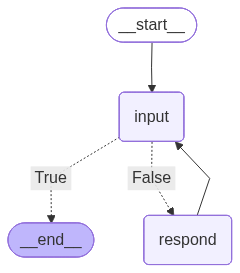

In [32]:
cot_chatbot = CoTChatbot(llm)

In [33]:
cot_chatbot.run("German")

================================ Human Message =================================

The user is asking a question. Please answer it using step-by-step reasoning. On each reasoning step, assess whether this reasoning step is good or not, on a scale from 1 to 10.

The user question is:

"What is the distance between the Earth and the Moon divided by the number of the planets in the Solar system?



================================== Ai Message ==================================

Schritt 1: Bestimmen wir die Entfernung zwischen der Erde und dem Mond. Die durchschnittliche Entfernung zwischen der Erde und dem Mond beträgt etwa 384.400 Kilometer. (Gute Bewertung: 9/10, da dies eine allgemein anerkannte Tatsache ist, aber die Entfernung variiert leicht aufgrund der elliptischen Umlaufbahn des Mondes.)

Schritt 2: Ermitteln wir die Anzahl der Planeten in unserem Sonnensystem. Nach den aktuellen wissenschaftlichen Erkenntnissen gibt es acht Planeten in unserem Sonnensystem: Merkur, Venus, Erde, 

<h2 id="rag">3. Basic RAG 💉</h2>

Now let's apply our new prompting tool to the basic RAG workflow. For that, we will just retrieve _k_ most relevant documents and them insert them into the prompt as a part of the context.

We will combine the skills we have obtained so far to build a LangGraph agent that receives an input, checks if the user wants to quit, then do the retrieval and generate a context-aware response if not. We will build on the basic version of our first chatbot; to add the RAG functionality, we need to add a retrieval node and modify the generation prompt to inject the retrieved documents.

LangGraph provides a pre-built tool to conveniently create a retriever tool. The retriever tool can be connected to the LLM; in this case, the LLM decides itself whether to use it or not. But for our RAG labs, we separate the tool from the LLM to concentrate on the retrieval and not the agentic aspect of the system (which will be covered in the next week's lab). We also won't generate queries for the retriever for now.

In [35]:
from langchain.tools.retriever import create_retriever_tool

In [131]:
# role: restrict it from the parametric knowledge
rag_system_prompt = """\
You are an assistant that has access to a knowledge base. \
You should use the knowledge base to answer the user's questions \
unless you can reliably answer them from your own knowledge.
"""


# this will add the context to the input
context_injection_prompt = """\
The user is asking a question. \
Answer using the following knowledge from the knowledge base:


==========================
{context}
==========================


The user question is:
{input}
"""


# finally, gather the system message, the previous messages,
# and the input with the context
rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", rag_system_prompt),   # system message
        MessagesPlaceholder(variable_name="messages"),  # previous messages
        ("user", context_injection_prompt)  # user message
    ]
)

In [134]:
class BasicRAGChatbot(Chatbot):

    _graph_path = "./graph_basic_rag.png"
    
    def __init__(self, llm, k=5):
        super().__init__(llm)
        self.rag_prompt = rag_prompt
        self.retriever = vector_store.as_retriever(search_kwargs={"k": k})    # retrieve 5 documents
        self.retriever_tool = create_retriever_tool(    # and this is the tool
            self.retriever,
            "retrieve_internal_data",  # name
            "Search relevant information in internal documents.",   # description
        )

    def _build(self):
        # graph builder
        self._graph_builder = StateGraph(SimpleState)
        # add the nodes
        self._graph_builder.add_node("input", self._input_node)
        self._graph_builder.add_node("retrieve", self._retrieve_node)
        self._graph_builder.add_node("respond", self._respond_node)
        # define edges
        self._graph_builder.add_edge(START, "input")
        # basic rag: no planning, just always retrieve
        self._graph_builder.add_conditional_edges("input", self._is_quitting_node, {False: "retrieve", True: END})
        self._graph_builder.add_edge("retrieve", "respond")
        self._graph_builder.add_edge("respond", "input")
        # compile the graph
        self._compile()
    
    def _retrieve_node(self, state: SimpleState) -> dict:
        # retrieve the context
        user_query = state["messages"][-1].content  # use the last message as the query
        context = self.retriever_tool.invoke({"query": user_query})
        # add the context to the messages
        return {
            "messages": AIMessage(content=context)
        }
    
    def _respond_node(self, state: SimpleState) -> dict:
        # the workflow is designed so that the context is always the last message
        # and the user query is the second to last message
        context = state["messages"].pop(-1).content # don't want the context in the messages
        user_query = state["messages"][-1].content
        prompt = self.rag_prompt.invoke(
            {
                "messages": state["messages"],  # this goes to the message placeholder
                "context": context,  # this goes to the user message
                "input": user_query    # this goes to the user message
            }
        )
        response = self.llm.invoke(prompt)
        # add the response to the messages
        return {
            "messages": response
        }

    def run(self):
        input = {"messages": []}
        for event in self.chatbot.stream(input, stream_mode="values"):
            if event["messages"]:
                event["messages"][-1].pretty_print()
                print("\n")

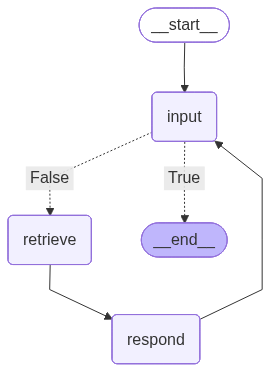

In [91]:
basic_rag_chatbot = BasicRAGChatbot(llm)

In [ ]:
basic_rag_chatbot.run()
# What sessions do I have about virtual assistants?
# What is the reading for the third one?

================================ Human Message =================================

What sessions do I have about virtual assistants?


================================== Ai Message ==================================

## LLM-based Assistants

Search

INFOS AND STUFF

Topics Overview

Debates

Pitches

LLM Inference Guide

BLOCK 1: INTRO

22.04. LLMs as a Form of Intelligence vs LLMs as Statistical Machines

24.04. LLM &amp; Agent Basics

29.04. Intro to LangChain

BLOCK 2: CORE TOPICS | PART 1: BUSINESS APPLICATIONS

06.05. Virtual Assistants Pt. 1: Chatbots

08.05. Basic LLM-based Chatbot

BLOCK 2: CORE TOPICS | PART 2: APPLICATIONS IN SCIENCE

Under development

BLOCK 3: WRAP-UP

Under development

## Topics Overview

The schedule is preliminary and subject to changes !

- LangGraph Quickstart: Build a Basic Chatbot (part 2), LangGraph
- Agentic RAG, LangGraph
- Adaptive RAG, LangGraph
- Multimodality, LangChain

## Week 5

## 20.05. Lecture : Virtual Assistants Pt. 3: Multi-agent Envi

As you can see, it already works pretty well, but as the retrieval goes by the user query directly, the previous context of the conversation is not considered by the _retriever_. To handle that, let's add a node that would reformulate the query taking in consideration the previous interactions.

For that, we need an additional prompt.

In [126]:
complete_query_prompt = ChatPromptTemplate.from_messages(
    [
        MessagesPlaceholder(variable_name="messages"),  # previous messages
        (
			"user",
			"Complete the following user query in the last message to a full question based on the previous messages. "
            "Return only the reformulated user query, without any other text. Do not expand the query "
			"or change its meaning and only fill in the missing information in the last question. "
			"\n\nUser query:\n{query}\n\nReformulated query:"
        )
    ]
)

In [127]:
class BasicPlusRAGChatbot(BasicRAGChatbot):

    _graph_path = "./graph_basic_plus_rag.png"

    def __init__(self, llm, k=5):
        super().__init__(llm, k)
        self.complete_query_prompt = complete_query_prompt

    def _build(self):
        # graph builder
        self._graph_builder = StateGraph(SimpleState)
        # add the nodes
        self._graph_builder.add_node("input", self._input_node)
        self._graph_builder.add_node("complete_query", self._complete_query_node)
        self._graph_builder.add_node("retrieve", self._retrieve_node)
        self._graph_builder.add_node("respond", self._respond_node)
        # define edges
        self._graph_builder.add_edge(START, "input")
        # basic rag: no planning, just always retrieve
        self._graph_builder.add_conditional_edges("input", self._is_quitting_node, {False: "complete_query", True: END})
        self._graph_builder.add_edge("complete_query", "retrieve")
        self._graph_builder.add_edge("retrieve", "respond")
        self._graph_builder.add_edge("respond", "input")
        # compile the graph
        self._compile()

    def _complete_query_node(self, state: SimpleState) -> dict:
        # since we use the generated query instead of the user query,
        # we want to remove the original user query from the messages
        # and replace it with the generated one, having converted it to a HumanMessage
        user_query = state["messages"].pop(-1)
        prompt = self.complete_query_prompt.invoke({
            **state,    # will take the messages from here
            "query": user_query.content   # and the user query from here
        })
        generated_query = self.llm.invoke(prompt)  
        return {
            "messages": [HumanMessage(content=generated_query.content)] # append the generated query to the messages
        }

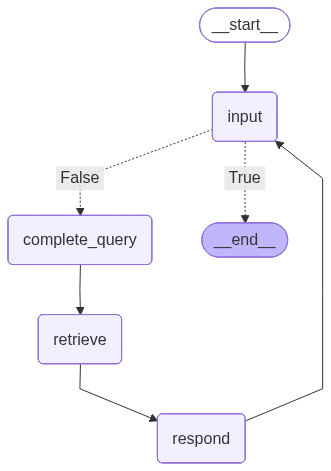

In [128]:
basic_plus_rag_chatbot = BasicPlusRAGChatbot(llm, k=7)

In [ ]:
basic_plus_rag_chatbot.run()
# What sessions do I have about virtual assistants?
# What is the reading for the third one?
# And about the second?

================================ Human Message =================================

What sessions do I have about virtual assistants?


================================ Human Message =================================

What sessions do I have scheduled about virtual assistants?


================================== Ai Message ==================================

## LLM-based Assistants

Search

INFOS AND STUFF

Topics Overview

Debates

Pitches

LLM Inference Guide

BLOCK 1: INTRO

22.04. LLMs as a Form of Intelligence vs LLMs as Statistical Machines

24.04. LLM &amp; Agent Basics

29.04. Intro to LangChain

BLOCK 2: CORE TOPICS | PART 1: BUSINESS APPLICATIONS

06.05. Virtual Assistants Pt. 1: Chatbots

08.05. Basic LLM-based Chatbot

BLOCK 2: CORE TOPICS | PART 2: APPLICATIONS IN SCIENCE

Under development

BLOCK 3: WRAP-UP

Under development

## Topics Overview

The schedule is preliminary and subject to changes !

- LangGraph Quickstart: Build a Basic Chatbot (part 2), LangGraph
- Agenti

<h2 id="adv_rag">4. Advanced RAG 😎</h2>

Now we can move to a more complicated implementation. We will now make an iterative RAG chatbot: this chatbot will retrieve contexts iteratively and decide at each step whether the chunks retrieved so far are sufficient to answer the question; the answer is generated only when the retrieved contexts are enough (or when the limit on number of the contexts is reached).

Basically, we have almost everything we need to implement an iterative RAG pipeline. We only need to add three more nodes:
1. A node to generate search queries for the index: now we won't use the user query but specifically generate queries for the index.
2. A decision node, in which the LLM will decide whether the context retrieved so far is enough to proceed to generation of the response.
3. Query transformer that will reformulate the query to retrieve further chunks when it's needed.

As a useful addition, we will also add LLM-based filtering of the retrieved documents to filter out the documents that are semantically similar to the query but are not really relevant for answering the question.

Thus, we need to add 4 nodes totally.

We will start with the grader that will output a binary score for the relevance: `True`(relevant) or `False` (irrelevant). To implement this functionality, we'll bind the LLM to a true/false structured output.

In [123]:
from pydantic import BaseModel, Field

In [124]:
class YesNoVerdict(BaseModel):
    verdict: bool = Field(..., description="Boolean answer to the given binary question.")

We will also need to transform the state to accumulate the contexts gathered so far.

In [139]:
class AdvancedRAGState(SimpleState): # "messages" is already defined in SimpleRAGState
    queries: List[str]            # this is the list of generated queries
    docs: List[List[Document]]    # this is the list of retrieved documents, one list per retrieval

And we also need prompts to (re)generate the query, to filter the retrieved documents, and to decide whether the contexts are supportive enough.

In [140]:
generate_query_template = """\
The user is now asking a question. \
Your task is to generate a query that will retrieve the most relevant documents \
from the knowledge base to answer the user question. \
Return the generated query only, without any other text.

Below is a list of previously generated queries, if any. \
All the previous queries retrieved documents that turned out to be insufficient \
to answer the user's question. Avoid repeating the previous queries \
and explore different aspects of the question.

Previous queries:
{previous_queries}

The user question is:
{input}

Your generated query:
"""

generate_query_prompt = ChatPromptTemplate.from_messages(
    [
		rag_system_prompt,
        ("user", generate_query_template)
    ]
)

In [ ]:
document_relevant_template = """\
The user is now asking a question. \
For answering the question, your colleague has retrieved the following document:


===========================
{document}
===========================


Your task is to assess whether this document is relevant to answer the user's question. \
Relevant means that the document contains specific information should be used \
directly to answer the user's question. \
Return True if the document is relevant, and False otherwise.


The user question is:
{input}
"""

document_relevant_prompt = ChatPromptTemplate.from_messages(
    [
		rag_system_prompt,
        ("user", document_relevant_template)
    ]
)

In [142]:
documents_sufficient_template = """\
The user is now asking a question. \
For answering the question, your colleague has retrieved the following documents:


===========================
{documents}
===========================


Your task is to assess whether the retrieved documents contain the answer to the user's question. \
Return True if the documents are sufficient, and False otherwise.


The user question is:
{input}
"""

documents_sufficient_prompt = ChatPromptTemplate.from_messages(
    [
		rag_system_prompt,
        ("user", documents_sufficient_template)
    ]
)

In [ ]:
class IterativeRAGChatbot(BasicPlusRAGChatbot):

    _graph_path = "./graph_iterative_rag.png"

    def __init__(self, llm, k=5, max_generations=4):
        super().__init__(llm, k)
        self.max_generations = max_generations
        self.boolean_llm = llm.with_structured_output(YesNoVerdict)
        self.generate_query_prompt = generate_query_prompt
        self.document_relevant_grader = document_relevant_prompt | self.boolean_llm
        self.documents_sufficient_grader = documents_sufficient_prompt | self.boolean_llm

    def _build(self):
        # graph builder
        self._graph_builder = StateGraph(AdvancedRAGState)
        # add the nodes
        self._graph_builder.add_node("input", self._input_node)
        self._graph_builder.add_node("complete_query", self._complete_query_node)
        self._graph_builder.add_node("generate_query", self._generate_query_node)
        self._graph_builder.add_node("retrieve", self._retrieve_node)
        self._graph_builder.add_node("filter_documents", self._filter_documents_node)
        self._graph_builder.add_node("respond", self._respond_node)
        # define edges
        self._graph_builder.add_edge(START, "input")
        # basic rag: no planning, just always retrieve
        self._graph_builder.add_conditional_edges("input", self._is_quitting_node, {False: "complete_query", True: END})
        self._graph_builder.add_edge("complete_query", "generate_query")
        self._graph_builder.add_edge("generate_query", "retrieve")
        self._graph_builder.add_edge("retrieve", "filter_documents")
        self._graph_builder.add_conditional_edges(
            "filter_documents",
            self._documents_sufficient_node,
            {
                False: "generate_query",
                True: "respond",
                None: END   # max generations reached
            }
        )
        self._graph_builder.add_edge("respond", "input")
        # compile the graph
        self._compile()

    def _generate_query_node(self, state: AdvancedRAGState) -> dict:    
        user_query = state["messages"][-1].content  # complete user query
        prompt = generate_query_prompt.invoke({
            # put previous queries
            "previous_queries": "\n".join(state["queries"]) or "NONE",
            "input": user_query
        })
        search_query = self.llm.invoke(prompt)
        return {
            "messages": search_query,
            "queries": state["queries"] + [search_query.content]  # could have also used `Annotated` here
        }

    # now store the contexts in the separate field
    def _retrieve_node(self, state: AdvancedRAGState) -> dict:    
        # retrieve the context
        query = state["messages"][-1].content  # the generated query
        # now use the retriever directly to get a list of documents and not a combined string
        contexts = self.retriever.invoke(query)
        # add the context to the messages
        return {
            "contexts": state["contexts"] + [contexts]  # could have also used `Annotated` here
        }
    
    def _filter_documents_node(self, state: AdvancedRAGState) -> dict:
        query = state["messages"][-1].content  # that will be the generated query
        # since the retrieved documents are graded at the same step,
        # we only need to pass the last batch of documents
        contexts = state["contexts"].pop(-1)  # will be replaced with the filtered ones
        # grade each document separately and only keep the relevant ones
        relevant_contexts = []
        for context in contexts:
            print("Grading document:\n\n", context.page_content)
            verdict = self.context_relevant_grader.invoke(
                {
                    "context": context.page_content,    # this is a Document object
                    "input": query
                }
            )
            print(f"Verdict: {verdict.verdict}")
            print(f"\n\n=====================\n\n")
            if verdict.verdict:    # boolean value according to the Pydantic model
                relevant_contexts.append(context)
        return {
            "contexts": state["contexts"] + [relevant_contexts]  # could have also used `Annotated` here
        }
    
    def _contexts_sufficient_node(self, state: AdvancedRAGState) -> dict:
        query = state["messages"][-2].content   # that will be the complete user query, -1 is the generated search query
        all_contexts = state["contexts"]
        # flatten and transform the list of lists into a single list
        contexts = [context for sublist in all_contexts for context in sublist]
        contexts_str = "\n\n".join([context.page_content for context in contexts])
        print("Deciding whether the documents are sufficient")
        verdict = self.contexts_sufficient_grader.invoke(
                {
                "contexts_str": contexts_str,    # this is a Document object
                "input": query
            }
        )
        print(f"Verdict: {verdict.verdict}")
        print(f"\n\n=====================\n\n")
        if not verdict.verdict and len(all_contexts) == self.max_generations:
            return  # will route to END
        return verdict.verdict
    
    def run(self):
        input = {"messages": [], "contexts": [], "suka": 0}
        for event in self.chatbot.stream(input, stream_mode="values"):
            if event["messages"]:
                event["messages"][-1].pretty_print()
                print("\n")

In [ ]:
# make small k to ensure one retrieval is not enough
iterative_rag_chatbot = IterativeRAGChatbot(llm, k=2)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
iterative_rag_chatbot.run()

================================ Human Message =================================

what are the key point of the next lecture after the one on 13.05


================================== Ai Message ==================================

What are the key points of the next lecture after the one scheduled for May 13th?


================================== Ai Message ==================================

lecture schedule May 13th next lecture key points


================================== Ai Message ==================================

lecture schedule May 13th next lecture key points


Grading document:

 12.05.25, 17:28Topics Overview - LLM-based Assistants
Page 1 of 12https://maxschmaltz.github.io/Course-LLM-based-Assistants/infos/topic_overview.html
To p i c s  O v e r v i e wThe schedule is preliminary and subject to changes!
The reading for each lecture is given as references to the sources the respective lectures base on. Youare not obliged to read anything. However, you are strongly enco